# Aufgabe 8
## Aufgabe 8.1
__Aufgabe:__ Implementation der LU Zerlegung mit Spaltenpivotsuche.

Zunächst laden der nötigen Befehle

In [1]:
from numpy import array,arange,triu,tril,eye

Es wird die Variante mit minimaler Schleifennzahl, also nur einer, gezeigt. Zusätzlich sind noch zwei Sicherungsmechanismen eingebaut, die garantieren, dass jeder Schritt im Algorithmus durchführbar ist.

In [2]:
def lu_pivot(A):
    # Input:
    # - A: Matrix von der die LU Zerlegung bestimt werden soll
    # Output:
    # - A: Matrix, die  die LU-Zerlegung enthält
    # - p: Vektor der die Pivotisierung speichert
    
    n,m=A.shape
    # Teste ob A quadratisch ist, wenn nicht Abbruch des Algorithmus
    if n!=m:
        print('Matrix nicht quadratisch')
        return None
    
    p=arange(n)
    for kkk in range(n):
        restSpalte=abs(A[kkk:,kkk])
        # Teste ob der näcshte Schritt durchführbar ist. Aus numerischer Sicht wäre es sinnvoller zu testen, ob
        # restSpalte.max()<EPS, wobei EPS ein kleine vorgegebene Zahl ist.
        if restSpalte.max()==0:
            print('0 auf Diagonale, Algorithmus nicht durchführbar')
            return None
        
        ind=restSpalte.argmax()
        # Teste ob Pivotisiert werden muss
        if ind!=0:
            # Führe Pivotisierung aus, diese ist ohne Schleife möglich, indem man  die beiden Zeilen komplett in 
            # einem Schritt tauscht.
            p[[kkk,kkk+ind]]=p[[kkk+ind,kkk]] 
            A[[kkk,kkk+ind],:]=A[[kkk+ind,kkk],:] 
        
        # Durchführung des nächsten Eliminationsschrittes, auch hier ohne Schleife. Der Trick ist den additiven Term
        # in der Berechnung der a_ij für i,j>k durch das passende Matrixprodukt darzustellen.
        l=A[kkk+1:,kkk]/A[kkk,kkk]; 
        A[kkk+1:,kkk]=l; 
        # Korrektur der Terme a_ij mit i,j>kkk. Dabei muss daran gedacht werden die  Vektoren l und A[kkk,kkk+1:] 
        # explizit als Spalten- bzw. Zeilenvektor darzustellen. Tut man dies nicht, verwendet python punktweise
        # Multiplikation und Broadcasting für die Rechnung (wirft also keinen Fehler aus), allerdings erhält man
        # nicht das gewünschte Ergebnis.
        A[kkk+1:,kkk+1:]=A[kkk+1:,kkk+1:]-l[:,None]@A[kkk,kkk+1:].reshape(1,-1);  
        
    return A,p

Die Ausgabe besteht nun aus der Überschriebenden Matrix A, die (L-I)+U enthält. Möchte man aus dieser die Matrix A rekonstruieren muss man zunächst L\*U berechnen und erhält dann die Zeilen von A in der in p gespeicherten Reihenfolge auslesen. Hier ein paar Beispiele: 

In [3]:
A=array([[2,-1,0],[-1,2,-1],[0,-1,2]])*1.0
B,p=lu_pivot(A)
print(p)
(tril(B,-1)+eye(3))@triu(B)

[0 1 2]


array([[ 2., -1.,  0.],
       [-1.,  2., -1.],
       [ 0., -1.,  2.]])

Hier wurde wir nicht getauschen (zu erkennen an p=[0,1,2]). Wichtig ist, dass wir A als array von Kommazahlen übergeben, sonst werden Rechenfehler auftauchen.

In [4]:
A=array([[1,7,4],[1,-1,4],[8,2,3]])*1.0
B,p=lu_pivot(A.copy())
print(p)
C=(tril(B,-1)+eye(3))@triu(B)
print(C-A[p,:])

[2 0 1]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -4.44089210e-16]]


Wir sehen, dass wir bis auf (unvermeidbare) numerische Rechenfehler das erwartete Ergebnis erhalten.
## Aufgabe 8.1
__Aufgabe:__ Erstellen der 2d-Poissonmatrix bei Schrittweise 1/n auf dem Einheitsquadrat und Betrachtung der relativen Entwicklung der Anzahl der Nulleinträge von der LU-Zerlgung der Matrix.

Wir kopieren zunächst einmal die Funktion zum Erstellen von Tridiagonalmatrizen von letzter Woche:

In [5]:
from numpy import zeros, count_nonzero
import matplotlib.pyplot as plt

In [6]:
def tridiag(a,b,c,n):
    A=zeros([n,n]) 
    for iii in range(n):
        if iii==0:
            A[iii,iii]=b 
            A[iii,iii+1]=c
        elif iii==n-1:
            A[iii,iii]=b
            A[iii,iii-1]=a
        else:
            A[iii,iii]=b
            A[iii,iii-1]=a
            A[iii,iii+1]=c
    return A

Diese werden wir nutzen um die Matrizen zu erstellen, die auf der Diagonale der 2d-Poissonmatrix sitzen.

In [7]:
def poisson2d_matrix(n):
    A=zeros([(n-1)**2,(n-1)**2]) # Hier speichern wie die Poissonmatrix rein
    B=tridiag(-1,4,-1,n-1) # Die Matrix entlang der Diagonalen
    C=-eye(n-1) # Die Matrix auf den Matrixnebendiagonalen
    # Jetzt bauen wir Matrix nach dem selben Prinzip zusammen, wie in tridiag:
    for iii in range(n-1): # für "blockweise" durchlaufen der Matrix
        ind=iii*(n-1) # Umrechnen von Blockindex zu Matrixindex
        A[ind:ind+(n-1),ind:ind+n-1]=B #Setzen des Diagonalblocks
        # Setzen der Nebendiagonalblöcke
        if iii==0:
            A[ind:ind+(n-1),ind+(n-1):ind+2*(n-1)]=C
        elif iii==n-2:
            A[ind:ind+(n-1),ind-(n-1):ind]=C
        else:
            A[ind:ind+(n-1),ind+(n-1):ind+2*(n-1)]=C
            A[ind:ind+(n-1),ind-(n-1):ind]=C
    return n**2*A

Test das die richtige Matrix bei rauskommt mit n=4 (sollte also eine $(4-1)^2\cdot(4-1)^2$ Matrix sein).

In [8]:
poisson2d_matrix(4)

array([[ 64., -16.,   0., -16.,  -0.,  -0.,   0.,   0.,   0.],
       [-16.,  64., -16.,  -0., -16.,  -0.,   0.,   0.,   0.],
       [  0., -16.,  64.,  -0.,  -0., -16.,   0.,   0.,   0.],
       [-16.,  -0.,  -0.,  64., -16.,   0., -16.,  -0.,  -0.],
       [ -0., -16.,  -0., -16.,  64., -16.,  -0., -16.,  -0.],
       [ -0.,  -0., -16.,   0., -16.,  64.,  -0.,  -0., -16.],
       [  0.,   0.,   0., -16.,  -0.,  -0.,  64., -16.,   0.],
       [  0.,   0.,   0.,  -0., -16.,  -0., -16.,  64., -16.],
       [  0.,   0.,   0.,  -0.,  -0., -16.,   0., -16.,  64.]])

Jetzt: Verhältnis der nicht Nulleinträge bestimmen, da der jupyter Server nicht so schnell ist nur bis n=51

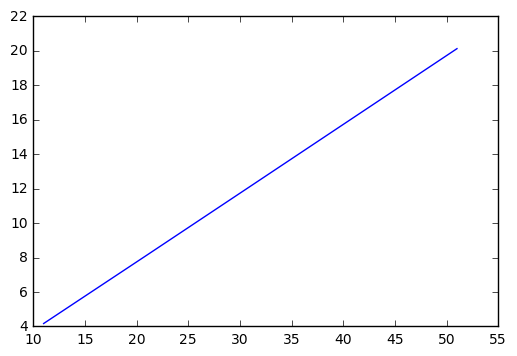

In [9]:
k=5
N=arange(k)*10+11
x=zeros(k)

for iii in range(k):
    A=poisson2d_matrix(N[iii])
    B,p=lu_pivot(A.copy())
    x[iii]=(1.0*count_nonzero(B))/count_nonzero(A)
    
plt.plot(N,x)
plt.show()